<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/Autoencoder/Sparse_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt

In [20]:
class SparseEncoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        #loss = l1 * reduce_sum(abs(x)) penalty loss가 더 작아 지도록 학습한다.
        super(SparseEncoder, self).__init__()
        self.hidden_layer = K.layers.Dense(hidden_dim, activation='relu', activity_regularizer=K.regularizers.l1(10e-5))

    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

class SparseDecoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(SparseDecoder, self).__init__()
        self.output_layer = K.layers.Dense(original_dim, activation='relu')

    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation

class SparseAutoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(SparseAutoencoder, self).__init__()
        self.loss = []
        self.encoder = SparseEncoder(hidden_dim=hidden_dim)
        self.decoder = SparseDecoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [21]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 0.01
hidden_dim = 64
original_dim = 784

In [22]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [23]:
def loss(y_real, y_pred):
    return tf.reduce_mean(tf.square(tf.subtract(y_pred, y_real)))

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(original, preds)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
    return reconstruction_error

def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [24]:
sparse_autoencoder = SparseAutoencoder(hidden_dim, original_dim)
optimizer = K.optimizers.Adam(learning_rate)

#train
train_loop(sparse_autoencoder, optimizer, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 5.368305683135986
Epoch 2/50. Loss: 3.6213138103485107
Epoch 3/50. Loss: 3.4651260375976562
Epoch 4/50. Loss: 3.435960292816162
Epoch 5/50. Loss: 3.416358709335327
Epoch 6/50. Loss: 3.4061524868011475
Epoch 7/50. Loss: 3.3850409984588623
Epoch 8/50. Loss: 3.3884437084198
Epoch 9/50. Loss: 3.3734848499298096
Epoch 10/50. Loss: 3.376483917236328
Epoch 11/50. Loss: 3.386622190475464
Epoch 12/50. Loss: 3.3681788444519043
Epoch 13/50. Loss: 3.3710663318634033
Epoch 14/50. Loss: 3.363248348236084
Epoch 15/50. Loss: 3.3643414974212646
Epoch 16/50. Loss: 3.3650076389312744
Epoch 17/50. Loss: 3.3795809745788574
Epoch 18/50. Loss: 3.357167959213257
Epoch 19/50. Loss: 3.372706651687622
Epoch 20/50. Loss: 3.3721961975097656
Epoch 21/50. Loss: 3.361032724380493
Epoch 22/50. Loss: 3.3615918159484863
Epoch 23/50. Loss: 3.376779079437256
Epoch 24/50. Loss: 3.3553035259246826
Epoch 25/50. Loss: 3.364596128463745
Epoch 26/50. Loss: 3.3560450077056885
Epoch 27/50. Loss: 3.37266564369201

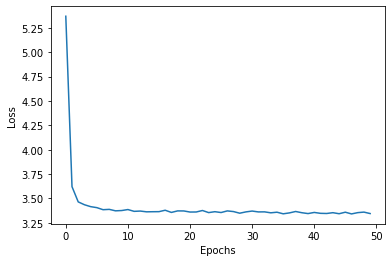

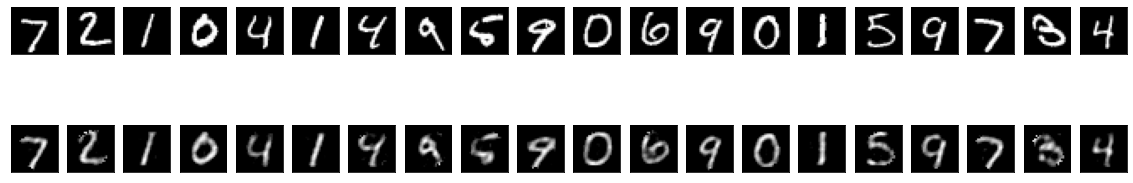

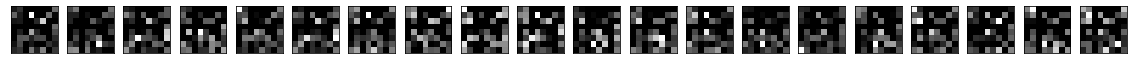

In [32]:
plt.plot(range(max_epochs), sparse_autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

encoder = sparse_autoencoder.encoder
number = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(sparse_autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#hidden dim
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(encoder(x_test)[index].numpy().reshape(8, 8), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
